<a href="https://colab.research.google.com/github/niyathimariya/bank-statements/blob/main/P1_BankStatements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load JSON data

In [2]:
data = 'P1- BankStatements.json'

In [5]:
with open(data, 'r') as file:
    data = json.load(file)

# Extract transactions

In [6]:
transactions = data['Account']['Transactions']['Transaction']

# Convert to DataFrame

In [7]:
df = pd.json_normalize(transactions)

# Convert transaction timestamp to datetime

In [8]:
df['transactionTimestamp'] = pd.to_datetime(df['transactionTimestamp'])

# Convert amount and currentBalance

In [9]:
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df['currentBalance'] = pd.to_numeric(df['currentBalance'], errors='coerce')

# 1. Transaction Analysis

# 1.1 Total number of transactions made over the **year**

In [10]:
total_transactions = len(df)
print("Total number of transactions:", total_transactions)

Total number of transactions: 985


# 1.2  Distribution of transaction amounts (small vs. large transactions)

Small transactions < 500

Large transactions ≥ 500.

In [11]:
small_transactions = df[df['amount'] < 500]
large_transactions = df[df['amount'] >= 500]

print("Number of small transactions:", len(small_transactions))
print("Number of large transactions:", len(large_transactions))

Number of small transactions: 687
Number of large transactions: 298


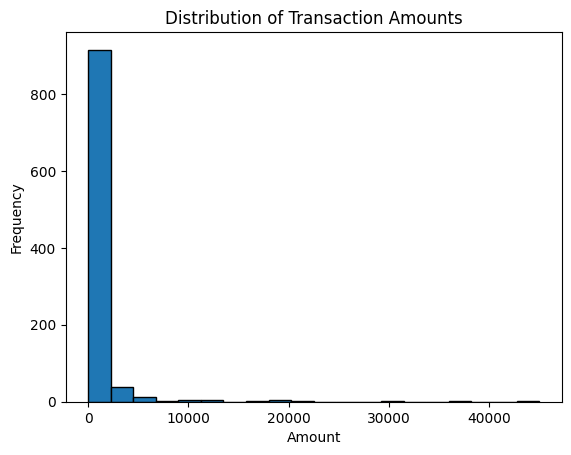

In [12]:
plt.hist(df['amount'], bins=20, edgecolor='k')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

Most of the transactions are below 10000

# 1.3 Frequency of different transaction types (debit vs. credit)

In [13]:
transaction_types = df['type'].value_counts()
print("Frequency of transaction types:")
print(transaction_types)

Frequency of transaction types:
type
DEBIT     695
CREDIT    290
Name: count, dtype: int64


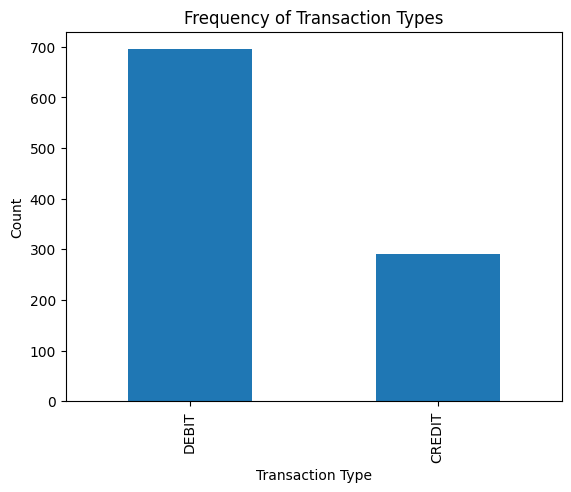

In [14]:
transaction_types.plot(kind='bar')
plt.title('Frequency of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

There is a significantly higher number of debit transactions (695) compared to credit transactions (290)

# 2 Balance Analysis

# 2.1 Trend of the account balance over time:

In [15]:
df.sort_values(by='transactionTimestamp', inplace=True)

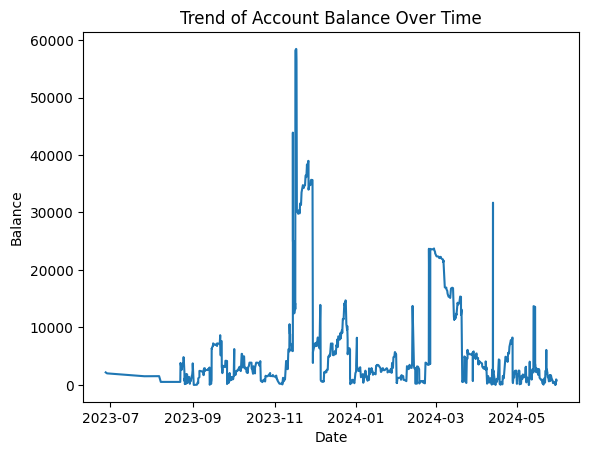

In [16]:
plt.plot(df['transactionTimestamp'], df['currentBalance'])
plt.title('Trend of Account Balance Over Time')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.show()

The average balance fluctuates; it increases significantly around November 2023 and then decreases again while remaining volatile.

# 2.2 Identify periods with significant changes in the account balance

In [17]:
df['balance_change'] = df['currentBalance'].diff()

In [18]:
significant_changes = df[abs(df['balance_change']) > 2000]
# Defined significant change threshold as 2000
print("Significant changes in account balance:")
print(significant_changes[['transactionTimestamp', 'balance_change']])

Significant changes in account balance:
         transactionTimestamp  balance_change
6   2023-08-22 11:49:13+05:30          3000.0
17  2023-08-25 10:24:38+05:30         -2480.0
51  2023-09-01 10:42:42+05:30         -3500.0
73  2023-09-13 10:19:32+05:30         -3000.0
78  2023-09-14 21:14:51+05:30          5500.0
..                        ...             ...
884 2024-05-13 06:54:41+05:30         11530.0
889 2024-05-14 11:51:56+05:30        -10000.0
930 2024-05-22 04:42:07+05:30          2050.0
935 2024-05-22 20:21:48+05:30          3920.0
936 2024-05-22 20:25:35+05:30         -3920.0

[76 rows x 2 columns]


# 3 Spending Patterns

# 3.1 Main categories of expenses

In [19]:
def categorize_expense(narration):
    if 'FILLING' in narration or 'FUEL' in narration:
        return 'Fuel'
    elif 'ATM' in narration:
        return 'ATM Withdrawals'
    elif 'UPI' in narration:
        return 'UPI Transactions'
    elif 'Ecom' in narration:
        return 'Ecommerce'
    elif 'Food' in narration:
        return 'Food'
    else:
        return 'Other'

In [20]:
df['category'] = df['narration'].apply(categorize_expense)

In [21]:
category_summary = df[df['type'] == 'DEBIT'].groupby('category').agg({'amount': ['sum', 'count']})
print("Spending by category:")
print(category_summary)

Spending by category:
                    amount      
                       sum count
category                        
ATM Withdrawals    13500.0     3
Fuel                 830.0     4
UPI Transactions  407759.9   688


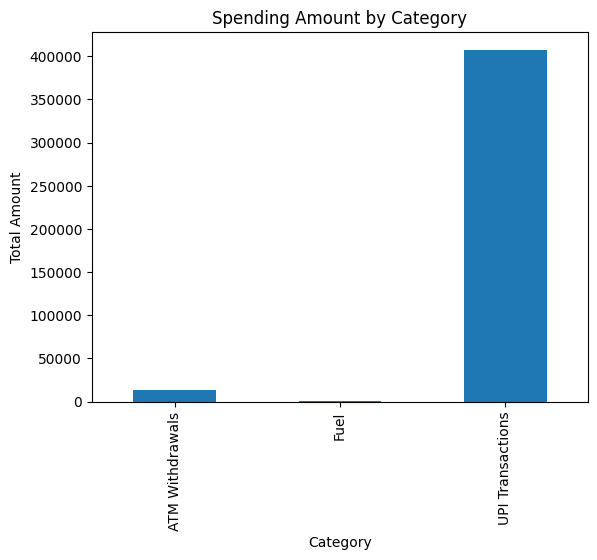

In [22]:
category_summary['amount']['sum'].plot(kind='bar')
plt.title('Spending Amount by Category')
plt.xlabel('Category')
plt.ylabel('Total Amount')
plt.show()

The major expenses are through UPI transactions indicating the shift to digital payments.But avergae spending per transaction is higher for ATM transactions(4,500.0). Fuel expenses are relatively low compared to UPI and ATM transactions.

# 4. Income Analysis

# 4.1 Main sources of income:

In [23]:
income_summary = df[df['type'] == 'CREDIT'].groupby('mode').agg({'amount': ['sum', 'count']})
print("Income by mode:")
print(income_summary)

Income by mode:
           amount      
              sum count
mode                   
CASH     45000.00     1
OTHERS  196237.51   188
UPI     179333.00   101


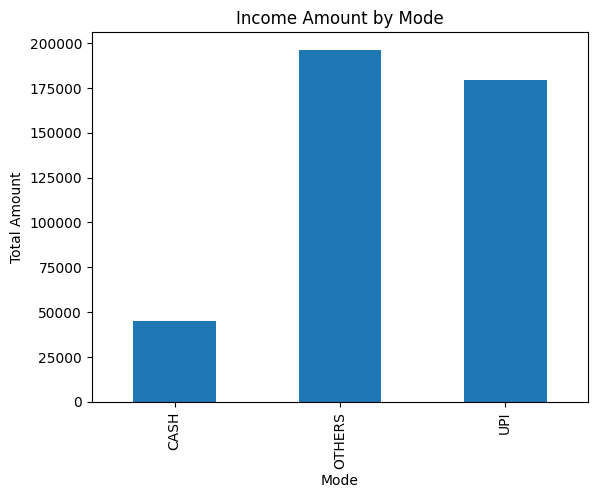

In [24]:
income_summary['amount']['sum'].plot(kind='bar')
plt.title('Income Amount by Mode')
plt.xlabel('Mode')
plt.ylabel('Total Amount')
plt.show()

The major source of income falls under others category(196237.51) followed by UPI Transaction(179333.00)

# 4.2 Patterns in the timing and amount of income received:

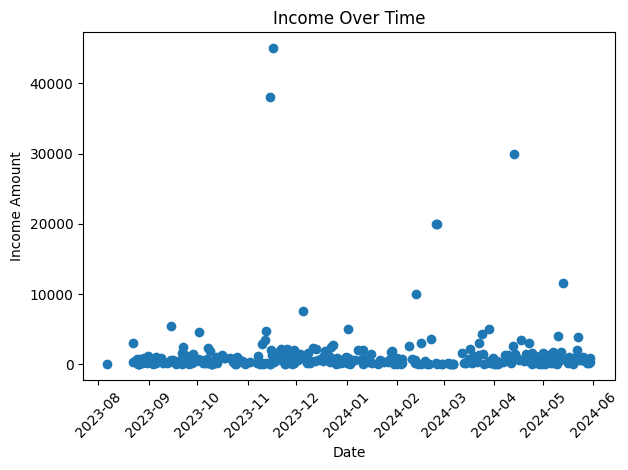

In [25]:
income_df = df[df['type'] == 'CREDIT']
plt.plot(income_df['transactionTimestamp'], income_df['amount'], 'o')
plt.title('Income Over Time')
plt.xlabel('Date')
plt.ylabel('Income Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The majority of income transactions are clustered at lower amounts, typically below 10,000 units of currency. This indicates that most income entries are relatively small.
Income amounts do not seem to increase or decrease significantly during specific times of the year.

# 5. Alert Generation
# 5.1 Identify unusual or suspicious transactions:

In [26]:
unusual_transactions = df[df['amount'] > 10000]
print("Unusual transactions:")
print(unusual_transactions[['transactionTimestamp', 'amount', 'narration']])

Unusual transactions:
         transactionTimestamp   amount  \
275 2023-11-14 18:31:11+05:30  37999.0   
277 2023-11-14 18:49:41+05:30  16500.0   
291 2023-11-16 15:51:14+05:30  45000.0   
295 2023-11-17 16:34:54+05:30  21000.0   
332 2023-11-29 16:15:33+05:30  19000.0   
333 2023-11-29 17:09:47+05:30  12700.0   
353 2023-12-05 15:50:06+05:30  13000.0   
570 2024-02-24 18:55:15+05:30  20000.0   
572 2024-02-25 11:08:34+05:30  20000.0   
576 2024-02-25 20:08:58+05:30  20000.0   
648 2024-03-20 18:56:48+05:30  12000.0   
743 2024-04-12 20:47:44+05:30  30000.0   
744 2024-04-12 20:50:06+05:30  30000.0   
884 2024-05-13 06:54:41+05:30  11530.0   

                                             narration  
275     UPI/331812106847/183112/UPI/311999sshuklaaxl/P  
277     UPI/331814821452/184941/UPI/7007674186paytm/UP  
291                                            BY CASH  
295     UPI/332126038252/163454/UPI/msjsrfashioneazypa  
332      UPI/333335900423/161532/UPI/mrking25icici/UPI  
333  

# 5.2 Generate alerts for low balance or high expenditure periods

In [27]:
low_balance_alerts = df[df['currentBalance'] < 500]
print("Low balance alerts:")
print(low_balance_alerts[['transactionTimestamp', 'currentBalance']])

Low balance alerts:
         transactionTimestamp  currentBalance
26  2023-08-25 16:56:59+05:30          175.80
27  2023-08-25 18:23:59+05:30          145.80
28  2023-08-25 18:37:02+05:30          196.80
29  2023-08-26 15:06:16+05:30          195.80
36  2023-08-27 12:19:54+05:30          315.80
..                        ...             ...
976 2024-05-29 08:53:10+05:30          178.41
977 2024-05-29 12:01:51+05:30           48.41
978 2024-05-29 17:10:42+05:30          348.41
979 2024-05-29 17:12:19+05:30          103.41
980 2024-05-29 17:57:40+05:30           23.41

[85 rows x 2 columns]


In [28]:
high_expenditure_alerts = df[(df['type'] == 'DEBIT') & (df['amount'] > 1000)]
print("High expenditure alerts:")
print(high_expenditure_alerts[['transactionTimestamp', 'amount', 'narration']])

High expenditure alerts:
         transactionTimestamp   amount  \
8   2023-08-23 08:17:48+05:30   1200.0   
17  2023-08-25 10:24:38+05:30   2480.0   
18  2023-08-25 10:39:35+05:30   1450.0   
36  2023-08-27 12:19:54+05:30   1499.0   
40  2023-08-29 11:49:00+05:30   1200.0   
..                        ...      ...   
848 2024-05-07 16:53:22+05:30   1500.0   
869 2024-05-10 15:13:20+05:30   2000.0   
889 2024-05-14 11:51:56+05:30  10000.0   
911 2024-05-17 18:51:36+05:30   1300.0   
936 2024-05-22 20:25:35+05:30   3920.0   

                                          narration  
8    UPI/323568910825/081748/UPI/8795417446ybl/Paym  
17   UPI/323779418599/102438/UPI/Q201531625ybl/Paym  
18   UPI/323723435211/103935/UPI/KAYUMTRADERSicici/  
36   UPI/323955508725/121953/UPI/9455566771ibl/Paym  
40   UPI/324141523213/114859/UPI/6393130981ibl/Paym  
..                                              ...  
848  UPI/449438113382/165322/UPI/8882239781ibl/Paym  
869  UPI/449780649234/151319/UPI/83039